# Real or Not? NLP with Disaster Tweets   
Predict which Tweets are about real disasters and which ones are not

environment:   
tensorflow 2.2.0  
karas 2.3.1   
sklearn 0.22.1   
platform: 
I7-9700k GTX-1080ti


## 1. Naive Bayes

In [1]:
import numpy as np 
import pandas as pd 
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
import seaborn as sns

### Input data
../train.csv                  7613   
../test.csv                   3263   
../sample_submission.csv      3263   

In [2]:
train_df = pd.read_csv("../train.csv")
test_df = pd.read_csv("../test.csv")
sub_df = pd.read_csv("../sample_submission.csv")
print (train_df.shape, test_df.shape, sub_df.shape)
# (7613, 5) (3263, 4) (3263, 2)

(7613, 5) (3263, 4) (3263, 2)


In [3]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### There is no duplicated data

In [4]:
train_df.duplicated().sum()

0

### The train set distribution

0    4342
1    3271
Name: target, dtype: int64

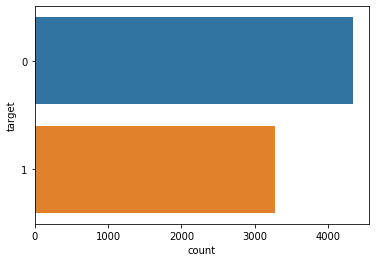

In [5]:
train_df = train_df.drop_duplicates().reset_index(drop=True)
sns.countplot(y=train_df.target);
train_df.target.value_counts()

### Separate the train.csv into 80% train data and 20% test data.

In [6]:
x = train_df["text"]
y = train_df["target"]


# Separate the train.csv into 80% train data and 20% test data.
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [7]:
X_train.head()

4996    Courageous and honest analysis of need to use ...
3263    @ZachZaidman @670TheScore wld b a shame if tha...
4907    Tell @BarackObama to rescind medals of 'honor'...
2855    Worried about how the CA drought might affect ...
4716    @YoungHeroesID Lava Blast &amp; Power Red #Pan...
Name: text, dtype: object

### Get stopword in sklearn.   
CountVectorizer(stop_words = 'english')

In [8]:
# Get stopword in sklearn.
vect = CountVectorizer(stop_words = 'english')

x_train_cv = vect.fit_transform(X_train)
x_test_cv = vect.transform(X_test)
vect

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
                lowercase=True, max_df=1.0, max_features=None, min_df=1,
                ngram_range=(1, 1), preprocessor=None, stop_words='english',
                strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
                tokenizer=None, vocabulary=None)

In [9]:
# sklearn.naive_bayes.MultinomialNB
clf = MultinomialNB()
clf.fit(x_train_cv, y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

In [10]:
pred = clf.predict(x_test_cv)

In [11]:
accuracy_score(y_test,pred)

0.7872619829284307

In [12]:
# output "submission_bayes.csv"
y_test = test_df["text"]
y_test_cv = vect.transform(y_test)
preds = clf.predict(y_test_cv)
sub_df["target"] = preds
sub_df.to_csv("submission_bayes.csv",index=False)

# 2. Bi-LSTM  
Using glove-twitter-27B vector representation of word.  
Bi-LSTM model
new version of tensorflow should use layers in tensorflow.keras 

In [13]:
import keras
import tensorflow as tf

from keras.layers import (LSTM, 
                          Embedding, 
                          BatchNormalization,
                          Dense, 
                          TimeDistributed, 
                          Dropout, 
                          Bidirectional,
                          Flatten, 
                          GlobalMaxPool1D)
from keras.models import Sequential
from keras.initializers import Constant

# new version of tensorflow should use layers in tensorflow.keras 
from tensorflow.keras import layers

from nltk.tokenize import word_tokenize
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers.embeddings import Embedding
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam


from sklearn.metrics import (
    precision_score, 
    recall_score, 
    f1_score, 
    classification_report,
    accuracy_score
)

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

Using TensorFlow backend.


In [14]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [15]:
keras.__version__

'2.3.1'

In [16]:
train = train_df.text.values
test = test_df.text.values
sentiments = train_df.target.values

In [17]:
word_tokenizer = Tokenizer()
word_tokenizer.fit_on_texts(train)
vocab_length = len(word_tokenizer.word_index) + 1

In [18]:
def metrics(pred_tag, y_test):

    print("F1-score: ", f1_score(pred_tag, y_test))
    print("Precision: ", precision_score(pred_tag, y_test))
    print("Recall: ", recall_score(pred_tag, y_test))
    print("Acuracy: ", accuracy_score(pred_tag, y_test))
    print("-"*50)
    print(classification_report(pred_tag, y_test))
    
def embed(corpus): 
    return word_tokenizer.texts_to_sequences(corpus)

In [19]:
longest_train = max(train, key=lambda sentence: len(word_tokenize(sentence)))
length_long_sentence = len(word_tokenize(longest_train))
padded_sentences = pad_sequences(embed(train), length_long_sentence, padding='post')

test_sentences = pad_sequences(
    embed(test), 
    length_long_sentence,
    padding='post'
)

### glove.twitter.27B-100d.txt
Pre-trained word vectors. 

In [20]:
# #Twitter Gloves

embeddings_dictionary = dict()
embedding_dim = 200
# glove_file = open('../input/glove-global-vectors-for-word-representation/glove.6B.' + str(embedding_dim) + 'd.txt', encoding="utf8")
glove_file = open('../../glove.twitter.27B.' + str(embedding_dim) + 'd.txt', encoding="utf8")

for line in glove_file:
    records = line.split()
    word = records[0]
    vector_dimensions = np.asarray(records[1:], dtype='float32')
    embeddings_dictionary [word] = vector_dimensions

glove_file.close()

In [21]:
embedding_matrix = np.zeros((vocab_length, embedding_dim))
for word, index in word_tokenizer.word_index.items():
    if index >= vocab_length:
        continue
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

In [22]:
def BLSTM():
    model = Sequential()
    model.add(Embedding(input_dim=embedding_matrix.shape[0], 
                        output_dim=embedding_matrix.shape[1], 
                        weights = [embedding_matrix], 
                        input_length=length_long_sentence,
                        trainable=False))
    
    model.add(Bidirectional(LSTM(length_long_sentence, return_sequences = True, recurrent_dropout=0.2)))
    model.add(GlobalMaxPool1D())
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(length_long_sentence, activation = "relu"))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation = 'sigmoid'))
    model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [23]:

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.2, 
    verbose =1, 
    patience=5,                        
    min_lr=0.001
)

for idx in range(5):
    
    print("*"*20 + '\nModelo: ' + str(idx) + '\n')
    
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.2, 
        verbose =1, 
        patience=5,                        
        min_lr=0.001
    )
    checkpoint = ModelCheckpoint(
        'model_' + str(idx)+ '.h5', 
        monitor='val_loss',
        mode='auto',
        verbose=1,
        save_weights_only = True,
        save_best_only=True
    )
    
    X_train, X_test, y_train, y_test = train_test_split(
        padded_sentences, 
        sentiments, 
        test_size=0.5
    )
    
    model = BLSTM()
    model.fit(X_train,
              y_train,
              batch_size=32,
              epochs=15,
              validation_data=[X_test, y_test],
              callbacks = [reduce_lr, checkpoint],
              verbose=1)

********************
Modelo: 0

Train on 3806 samples, validate on 3807 samples
Epoch 1/15
3806/3806 [==============================] - 22s 6ms/step - loss: 0.7081 - accuracy: 0.6432 - val_loss: 0.6185 - val_accuracy: 0.6961

Epoch 00001: val_loss improved from inf to 0.61854, saving model to model_0.h5
Epoch 2/15
3806/3806 [==============================] - 21s 5ms/step - loss: 0.5423 - accuracy: 0.7520 - val_loss: 0.5268 - val_accuracy: 0.7896

Epoch 00002: val_loss improved from 0.61854 to 0.52679, saving model to model_0.h5
Epoch 3/15
3806/3806 [==============================] - 20s 5ms/step - loss: 0.4821 - accuracy: 0.7909 - val_loss: 0.4769 - val_accuracy: 0.8019

Epoch 00003: val_loss improved from 0.52679 to 0.47691, saving model to model_0.h5
Epoch 4/15
3806/3806 [==============================] - 20s 5ms/step - loss: 0.4666 - accuracy: 0.8022 - val_loss: 0.4745 - val_accuracy: 0.7857

Epoch 00004: val_loss improved from 0.47691 to 0.47448, saving model to model_0.h5
Epoch 5/

3806/3806 [==============================] - 20s 5ms/step - loss: 0.3669 - accuracy: 0.8468 - val_loss: 0.4383 - val_accuracy: 0.8143

Epoch 00008: val_loss did not improve from 0.43716
Epoch 9/15
3806/3806 [==============================] - 20s 5ms/step - loss: 0.3352 - accuracy: 0.8597 - val_loss: 0.4723 - val_accuracy: 0.8159

Epoch 00009: val_loss did not improve from 0.43716
Epoch 10/15
3806/3806 [==============================] - 20s 5ms/step - loss: 0.3362 - accuracy: 0.8586 - val_loss: 0.5195 - val_accuracy: 0.8040

Epoch 00010: ReduceLROnPlateau reducing learning rate to 0.001.

Epoch 00010: val_loss did not improve from 0.43716
Epoch 11/15
3806/3806 [==============================] - 20s 5ms/step - loss: 0.3251 - accuracy: 0.8613 - val_loss: 0.4814 - val_accuracy: 0.8098

Epoch 00011: val_loss did not improve from 0.43716
Epoch 12/15
3806/3806 [==============================] - 20s 5ms/step - loss: 0.2959 - accuracy: 0.8778 - val_loss: 0.5821 - val_accuracy: 0.8025

Epoch 000


Epoch 00015: val_loss did not improve from 0.43036


In [24]:
%%time
from glob import glob
import scipy

x_models = []
labels = []

# Carregando os Modelos
for idx in glob('*.h5'):
    model = BLSTM()
    model.load_weights(idx)
    x_models.append(model)
    
# Predizendo Classes para o conjunto de Testes
for idx in x_models:
    preds = idx.predict_classes(test_sentences)
    labels.append(preds)

#Votando nas classes, baseando na moda estatística 
labels = scipy.stats.mode(labels)[0]
labels = np.squeeze(labels)   

CPU times: user 19 s, sys: 551 ms, total: 19.5 s
Wall time: 11.5 s


[1 1 1 ... 1 1 0]


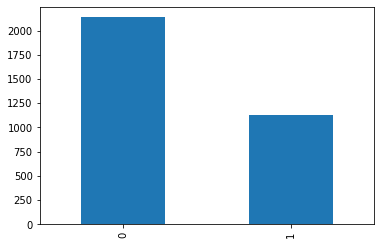

In [25]:
sub_df.target = labels
print(labels)
sub_df.to_csv("submission-bilstm.csv", index=False)
sub_df.target.value_counts().plot.bar();

## 3. There is a data called "socialmedia-disaster-tweets-DFE.csv",  posted by kaggle  
This dataset stems from the figure-eight (formally known as Crowdflower). There do have the prediction of the case we are doing. It's cheating so I just leave there but not submit the answer.  
https://www.kaggle.com/jannesklaas/disasters-on-social-media

In [26]:
ans = pd.read_csv("../socialmedia-disaster-tweets-DFE.csv", encoding='latin_1')
ans['target'] = (ans['choose_one']=='Relevant').astype(int)
ans['id'] = ans.index
ans = ans[['id', 'target','text']]
merged_df = pd.merge(test_df, ans, on='id')
sub1 = merged_df[['id', 'target']]
sub1.to_csv('submit_socialmedia_data.csv', index=False)